# Understanding South by SouthWest

* Group Members:
    * Karanja Gakio
    * Eunice Nduati
    * Jane Mwangi

 ## Business Understanding

The South by Southwest (SXSW) conference, a prominent annual event highlighting technological and creative industry advancements, is keen on improving attendee experiences in future editions. To achieve this, the company aims to analyze sentiment from historical tweets related to the event. 


## Business Problem
The primary business problem is the need for a reliable and accurate sentiment analysis model that can effectively determine the sentiment conveyed in tweets associated with SXSW. The analysis of historical tweets is crucial for gaining insights into the public perception of the conference and the brands featured during the event. Additionally, the company aims to implement real-time sentiment tracking during ongoing events to provide a timely gauge of their reception. Developing a robust sentiment analysis model is essential for making data-driven decisions to improve and optimize the overall attendee experience at SXSW.

## Data Understanding
Our analysis will utilize a dataset provided by CrowdFlower, comprising approximately 9,000 tweets associated with past SXSW events. This dataset includes three key components:

1.Text: The actual content of the tweet.

2. Product: This field specifies whether the tweet pertains to a product or brand from Apple or Google.

3. Sentiment: The sentiment expressed in the tweet is categorized into:
- 'Negative'
- 'Positive'
- 'No Emotion'

By leveraging this dataset, we aim to build a robust sentiment analysis model that can effectively interpret and categorize the emotional tone of tweets, thereby offering valuable insights for enhancing future SXSW events.

## Business Objectives
 1. To find out the most commonly used words in negative sentiments.
 2. To identify the most commonly used words in positive sentiments.
 3. Product sentiment analysis.
 4. Market research.


First we load necessary libraries 

In [124]:
#Loading necessary Libraries
import pandas as pd
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
from sklearn.model_selection import train_test_split
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from nltk import bigrams
from nltk import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from wordcloud import WordCloud
import warnings
from sklearn.metrics import classification_report
from collections import Counter
warnings.filterwarnings('ignore')
import re
import unicodedata
from nltk import pos_tag 
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, GRU, Dense
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')
# nltk.download('punkt')
#nltk.download('all')
#from sklearn.metrics import plot_confusion_matrix

### Data Cleaning

#### Loading dataset
We load the dataset using pandas and check the first five entries.

In [2]:
#loading dataset
df = pd.read_csv("data_from_tweets.csv", encoding='latin-1')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


#### Changing column names
From the above output, the tweets are labeled as 'Negative', 'Positive', or 'No Emotion' and identify the brand or product they are related to. The column names are too long. We rename them for easy reference as we work with the data set using the code below,

In [3]:
# Renaming columns
df = df.rename(columns={'tweet_text': 'text', 
                'emotion_in_tweet_is_directed_at' : 'product', 
                'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'})
df.head()

,text,product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


The changes have been effected. Next we will run code to check the overall dataframe information

In [4]:
# Checking dataframe information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       9092 non-null   object
 1   product    3291 non-null   object
 2   sentiment  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


#### Missing values
Let's also check for null values as follows:

In [5]:
# Checking for sum of the missing values
df.isna().sum()

text            1
product      5802
sentiment       0
dtype: int64

The dataset has some missing values. Text column has only one missing value and product column has 5,802. We can safely remove missing value from text column without causing a major impact on our data.

In [6]:
# Removing the one missing value entry from text
df.dropna(subset= ['text'], inplace = True)
df.isna().sum()

text            0
product      5801
sentiment       0
dtype: int64

Next we will reset the dataframe index in order to be able to iterate through the dataset based on index.

In [7]:
# Reset the dataframe index
df.reset_index(drop=True, inplace=True)
df.head()

,text,product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


The product column had the highest number of missing values recorded. We would like to look at the column to get more insight from the missing values so we can determine how to handle them.


In [8]:
#Exploring product column
df['product'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: product, dtype: int64

All the values are either under Google or Apple. We need to change the values to reflect the brand instead of their individual products.

In [9]:
# Get unique values in the 'product' column of the DataFrame
df['product'].unique()


array(['iPhone', 'iPad or iPhone App', 'iPad', 'Google', nan, 'Android',
       'Apple', 'Android App', 'Other Google product or service',
       'Other Apple product or service'], dtype=object)

We categorize our product values to as either Google or Apple

In [10]:
# Categorizing our product values as either Google or Apple

for index in range(len(df)):
    if df['product'][index] in ['iPhone', 'iPad or iPhone App', 
                                'iPad', 'Apple', 
                                'Other Apple product or service']:
        df['product'][index] = 'Apple'
    elif df['product'][index] in ['Google', 'Android', 
                                  'Android App', 
                                  'Other Google product or service']:
        df['product'][index] = 'Google'
    else:
        pass
df['product'].value_counts()

Apple     2409
Google     882
Name: product, dtype: int64

Checking the sum of missing values after the above changes

In [11]:
#We confirm the number of missing values from product column again
df.isna().sum()

text            0
product      5801
sentiment       0
dtype: int64

Since we are still missing so many product labels, we will iterate through the tweet texts to find words pertaining to either Apple or Google. This will help us to identify many of our missing labels. We will first convert the text to lowercase in order to capture any words pertaining to the brand in question.

In [12]:
# Normally, this step would be in language Processing part but we want to capture as many entries as we can identify from the tweets to help identify the product
df['text'] = df['text'].str.lower()

# Iterating through the tweets to find words pertaining to either Apple or Google
google_words = ['android', '#google', 'google']
apple_words = ['iphone', 'ipad', 'mac', 'apple', '#apple']

for index in range(len(df)):
    if any(word in df['text'][index] for word in google_words) == True:
        df['product'][index] = 'Google'
    else:
        pass
for index in range(len(df)):
    if any(word in df['text'][index] for word in apple_words) == True:
        df['product'][index] = 'Apple'
    else:
        pass

We get the value count of each product to see if the above changes have assisted in identifying the products

In [13]:
df['product'].value_counts()

Apple     5569
Google    2767
Name: product, dtype: int64

The step has successfully helped in product identification and reduction of the total missing values as shown in the output below

In [14]:
# We check the total missing values now
df.isna().sum()


text           0
product      756
sentiment      0
dtype: int64

For the remaining missing values we can assign 'unknown' as they will not affect our data that much.

In [15]:
# Assigning 'unknown' to the missing values in the product column
df.fillna(value='Unknown', inplace = True)

Checking if we have any more missing values in the dataset.

In [16]:
df['product'].isna().sum()

0

Great! Now we have dealt with all the missing values. We can now explore the target, sentiment.

In [17]:
# Checking values for sentiment
df['sentiment'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: sentiment, dtype: int64

Tweets where the sentiment cannot be discerned will not help our model. Therefore, we will remove these tweets from our dataset

In [18]:
# Removing entries where sentiment is "I can't tell"
df = df[df['sentiment'] != "I can't tell"]

In [19]:
df['sentiment'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
Name: sentiment, dtype: int64

The sentiment "No emotion toward brand or product " is an ambiguous expression it's more reasonable for it to read " neutral emotion" for easier refrence let's work on that below ;

In [20]:
df['sentiment'] = df['sentiment'].replace('No emotion toward brand or product', 'Neutral emotion')

#confirming change after replacement 
df['sentiment'].value_counts()

Neutral emotion     5388
Positive emotion    2978
Negative emotion     570
Name: sentiment, dtype: int64

Upon analyzing the sentiment distribution, it becomes apparent that there is a significant imbalance among the different sentiments, Neutral emotion, Positive emotion, and Negative emotion toward the brand or product.

#### Duplicates 

Finally we need to check for duplicate data and remove them if any

In [21]:
#checking any duplicates 

df.duplicated().any()

True

In [22]:
# removing duplicates 
df = df.drop_duplicates()

#confriming dataset without duplicates 
df.duplicated().any()

False

# Exploratory Data Analysis

We are now going to perform EDA analysis on our DataSet to further understand and gain insights from our data. Our analysis will include;

_Overall Sentiment distribution 

_Examining the distribution of unique words in the dataset and Generating word clouds to visually represent the most frequent words in the dataset

__Analyze Hashtags and Mentions

#### Overall Sentiment Distribution

First we separate EDA dataset so as to keep the original dataframe clean for further modelling

In [23]:

#showing the sentiment column value counts before the distribution 
df2 = df
df2['sentiment'].value_counts()

Neutral emotion     5359
Positive emotion    2966
Negative emotion     569
Name: sentiment, dtype: int64

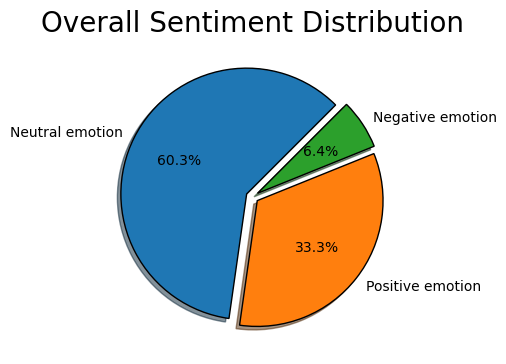

In [24]:
#seting slices and labels of every eomtion
slices = df2['sentiment'].value_counts().values
labels = df2['sentiment'].value_counts().index 
explode = [0.05, 0.05, 0.05]

# Seting figsize 
plt.figure(figsize=(5, 5))

# Creating a pie chart for effective visual distribution 
plt.pie(slices, labels=labels, wedgeprops={'edgecolor': 'black'}, explode=explode, shadow=True, autopct='%1.1f%%', startangle=45)
plt.title('Overall Sentiment Distribution', fontsize=20)
plt.tight_layout()
plt.show()

The analysis reveals a predominant expression of Neutral emotion, encompassing 60.3% of the dataset. Positive emotion follows at 33.3%, while Negative emotion is the least represented, covering only 6.4% of the dataset. While this provides a broad perspective, for a more granular examination, we will proceed to analyze sentiment distribution based on individual products: Google, Apple, or Unknown.

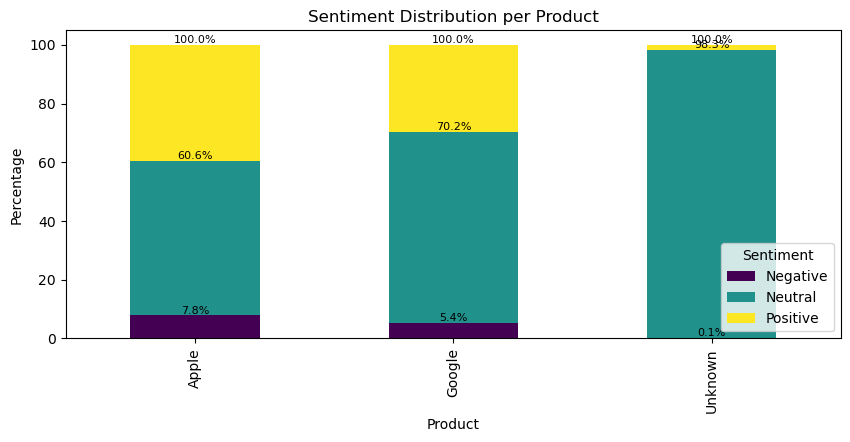

In [25]:
# creating a DataFrame grouped by product and sentiment
grouped_df = df2.groupby('product')['sentiment'].value_counts().unstack().fillna(0)

#Normalizing the sentiment counts to get the percentage distribution.
grouped_df = grouped_df.div(grouped_df.sum(axis=1), axis=0) * 100

#reshaping the product column in levels that read their sentiment elements by percentage 
grouped_df = df.groupby('product')['sentiment'].value_counts(normalize=True).unstack().fillna(0) * 100

# Plotting a stacked bar plot for each product with exact percentages
ax = grouped_df.plot(kind='bar', stacked=True, colormap='viridis', figsize=(10, 4))

# Adding percentage labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%1.1f%%', label_type='edge', fontsize=8)

plt.title('Sentiment Distribution per Product')
plt.xlabel('Product')
plt.ylabel('Percentage')
plt.legend(title='Sentiment', loc='lower right', labels=['Negative', 'Neutral', 'Positive'])
plt.show()

The above result translate to following 

Apple Product: 
Negative Emotion: 7.8%
Neutral Emotion: 60.6%
Positive Emotion: 31.6%

Google Product:
Negative Emotion: 5.4%
Neutral Emotion: 70.2%
Positive Emotion: 24.4%

Unknown Product:
Negative Emotion: 0.1%
Neutral Emotion: 98.3%
Positive Emotion: 1.6%

_Based on the afore_mentioned findings, it can be concluded that tweets exhibit a diverse sentiment landscape. Notably, in the case of Apple, a significant 60.6% fall into the neutral category, suggesting a balance of opinions. Positive sentiments are prevalent at 31.6%, while negative sentiments, though present at 7.8%, are less pronounced. On the other hand, discussions about Google lean heavily towards neutrality, comprising a substantial 70.2%. Positive sentiments are moderately expressed at 24.4%, reflecting a generally positive perception, while negative sentiments are relatively low at 5.4%. Tweets related to an unknown product predominantly convey a neutral sentiment, accounting for an overwhelming majority at 98.3%. Positive sentiments are observed at 1.6%, and negative sentiments are minimal at 0.1%. The sentiment dynamics across these products provide valuable insights into public perceptions, indicating areas of strength and improvement for each category.

#### Exploring Unique Words and Analyzing Their Frequency 

We will first  make a tokenized column and remove special characters for noice reduction and simplification so as we focus on core words that will carry meaning related to our target sentiment feature.

In [26]:
# Defining stopwords
sw = stopwords.words('english')
sw.extend(["apple", "google", "ipad", "iphone", "android", "sxsw", "link", "mention", "sxwsi", "hmmm","rt" "sxswu", "goog", "iusxsw",
           "etc", "via", "today", "hmmmm"])
#tokenizer function 
def pre_processor(doc, stop_words=sw):
    # Normalizing using The Unicode Normalization technique for entire strings
    doc = unicodedata.normalize('NFKD', doc).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # Removing URLs
    doc = re.sub(r'http\S+|www\S+|https\S+', '', doc, flags=re.MULTILINE)
    #Removing Mentions and hashtags
    doc = re.sub(r'\@\w+|\#','', doc)
    #Removing Punctuation and numbers
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    # Making all words lowercase
    doc = [word.lower() for word in doc]
    # Removing stopwords:
    doc = [word for word in doc if word not in sw]
    doc = [word for word in doc if len(word) > 2]  
    # We assign each word in tweet text
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    # Lemmatizing
    lemmatizer = WordNetLemmatizer()
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  

In [27]:
#applying our function for preprocessing
df2['tokens'] = df2['text'].apply(pre_processor)

#creating a tokenized column
df2['tokens'] = df2['tokens'].apply(lambda x: word_tokenize(x))

#viewing the dataset after tokenization 
df2.head()

,text,product,sentiment,tokens
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,Apple,Negative emotion,"[hr, tweet, rise, austin, dead, need, upgrade,..."
1,@jessedee know about @fludapp ? awesome ipad/i...,Apple,Positive emotion,"[know, awesome, app, likely, appreciate, desig..."
2,@swonderlin can not wait for #ipad 2 also. the...,Apple,Positive emotion,"[wait, also, sale]"
3,@sxsw i hope this year's festival isn't as cra...,Apple,Negative emotion,"[hope, year, festival, crashy, year, app]"
4,@sxtxstate great stuff on fri #sxsw: marissa m...,Google,Positive emotion,"[great, stuff, fri, marissa, mayer, tim, reill..."


Great Progress !! - let's proceed to get our unique words  

In [28]:
#creating a set of unique words from our tokens column 
unique_words = set(word for tokens in df2['tokens'] for word in tokens)
num_unique_words = len(unique_words)

#printing number of unique words 
print(f"Number of Unique Words: {num_unique_words}")

Number of Unique Words: 7575


we have identified 7575 unique words in our tokens column lets go ahead visualize the top 20 of them,in a countplot, bigram, word cloud and Trigram

#### Countplot 

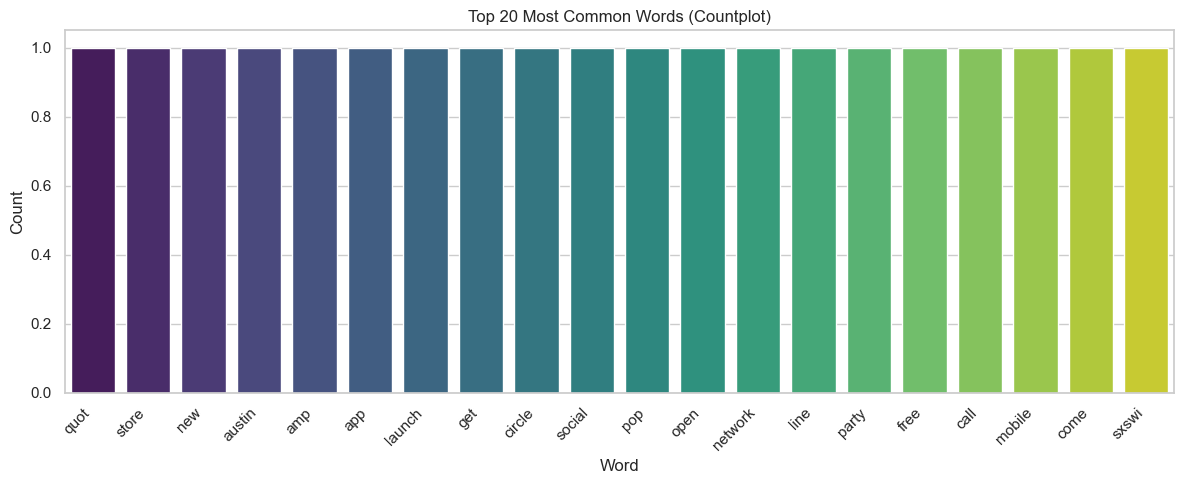

In [29]:
# list comprehension for words in tokens column 
all_tokens = [word for tokens in df2['tokens'] for word in tokens]
word_counts = Counter(all_tokens)

# Geting the top 20 most common words
top_words = word_counts.most_common(20)
labels, counts = zip(*top_words)

# Creating a DataFrame for Seaborn
data = {'Word': labels, 'Count': counts}
df_top_words = pd.DataFrame(data)

# Plotting a countplot
plt.figure(figsize=(12, 5))
sns.set(style="whitegrid")
ax = sns.countplot(x='Word', data=df_top_words, palette="viridis")

# Rotate x-axis labels by 45 degrees
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.title('Top 20 Most Common Words (Countplot)')
plt.xlabel('Word')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

#### Bigram 

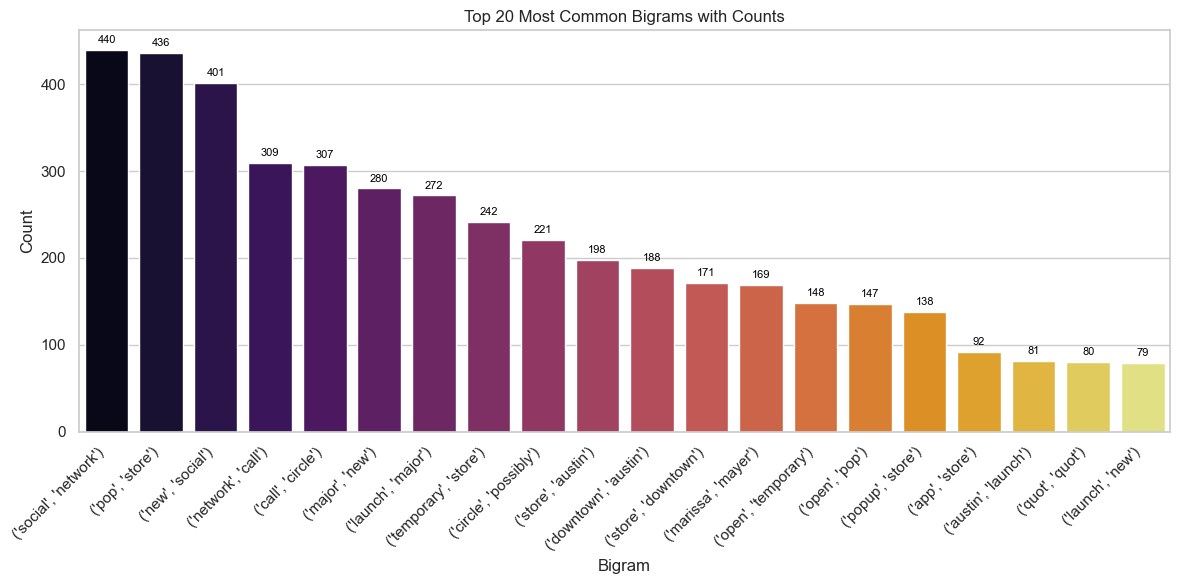

In [30]:
# list comprehension for words in the tokens column
all_tokens = [word for tokens in df2['tokens'] for word in tokens]

# Generating bigrams from the list of tokens
bi_grams = list(bigrams(all_tokens))

# Calculating the frequency of each bigram
bi_gram_counts = Counter(bi_grams)

# Getting the top 20 most common bigrams
top_bigrams = bi_gram_counts.most_common(20)
labels, counts = zip(*top_bigrams)

# Creating a DataFrame for Seaborn
data = {'Bigram': labels, 'Count': counts}
df_top_bigrams = pd.DataFrame(data)

# Plotting a countplot with counts displayed on top of bars
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
ax = sns.barplot(x='Bigram', y='Count', data=df_top_bigrams, palette="inferno")

# Rotating x-axis labels by 45 degrees for visibility ease
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Displaying counts on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=8, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('Top 20 Most Common Bigrams with Counts')
plt.xlabel('Bigram')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

#### Trigram

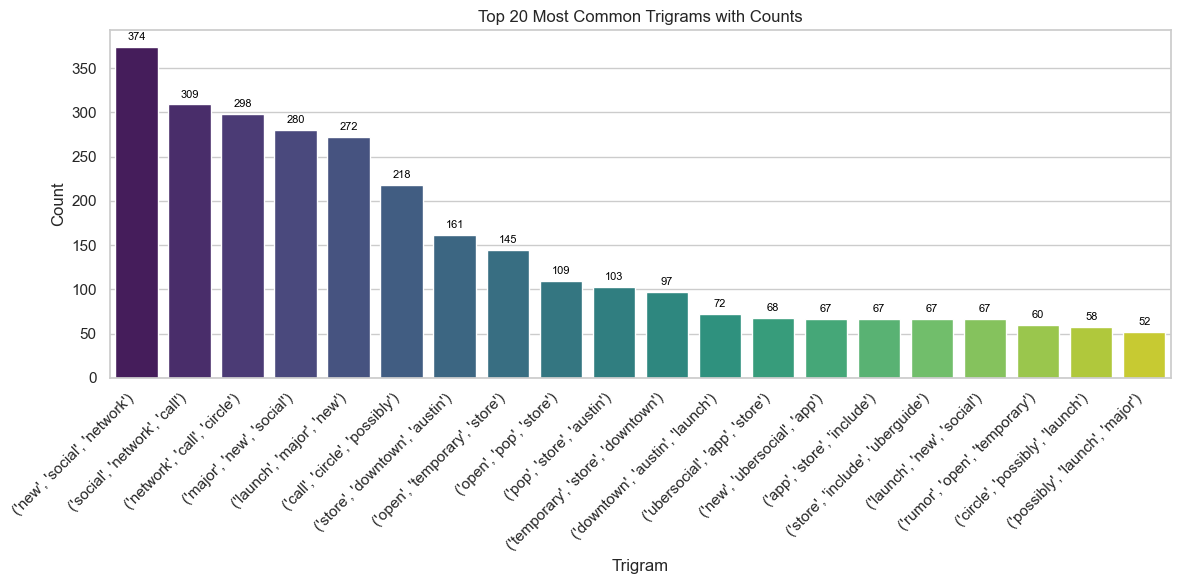

In [135]:
from nltk import trigrams
# List comprehension for words in the tokens column
all_tokens = [word for tokens in df2['tokens'] for word in tokens]

# Generating trigrams from the list of tokens
tri_grams = list(trigrams(all_tokens))

# Calculating the frequency of each trigram
tri_gram_counts = Counter(tri_grams)

# Getting the top 20 most common trigrams
top_trigrams = tri_gram_counts.most_common(20)
labels, counts = zip(*top_trigrams)

# Creating a DataFrame for Seaborn
data = {'Trigram': labels, 'Count': counts}
df_top_trigrams = pd.DataFrame(data)

# Plotting a countplot with counts displayed on top of bars
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
ax = sns.barplot(x='Trigram', y='Count', data=df_top_trigrams, palette="viridis")

# Rotating x-axis labels by 45 degrees for visibility ease
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Displaying counts on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=8, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('Top 20 Most Common Trigrams with Counts')
plt.xlabel('Trigram')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

#### Word Cloud 

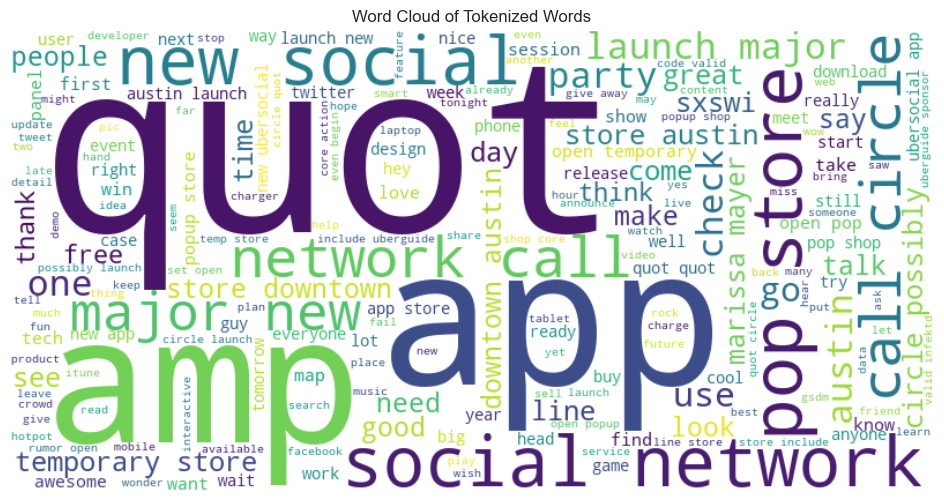

In [31]:
# list comprehension for words in the tokens column
all_tokens = [word for tokens in df2['tokens'] for word in tokens]

# Joining the list of tokens into a single string
text = ' '.join(all_tokens)

# Generating a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plotting the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tokenized Words')
plt.show()

Based on the insights derived from the countplot, bigram analysis, and word cloud on unique words related to the Apple and google products  during the SXSW event,several notable observations can be made.


#### Location Focus:
The analysis indicates a significant focus on a particular Apple store located in downtown Austin.
The trigram ('store', 'downtown', 'austin') suggests that this specific store garnered the most attention during the SXSW event.

#### Possibly a Pop-Up Store:
There are indications that this Apple store in downtown Austin might have been a temporary or pop-up store. Phrases such as ('temporary', 'store', 'downtown') and ('pop', 'store', 'Apple')  hint at the possibility that this store was a pop-up, and there is speculation or curiosity about its return.

#### Speculation and Sentiment:
The mention of a "pop-up" and the association with the term 'speculative sentiment' suggest that there may have been uncertainty or anticipation regarding the return of the pop-up store in subsequent years. This speculation is reinforced by the reference to a search for "Apple pop-up store SXSW Austin Texas" and the lack of conclusive information.

#### UberSocial App:

The analysis identifies UberSocial as a prominent app,it's well displayed in the WORDCLOUD('uber social app') and in the trigram ('new', 'ubersocial', 'app').  This suggests that there was buzz or attention around UberSocial during the SXSW event.
Despite UberSocial being launched in 2010, the use of the word "new" in association with it raises questions and curiosity. It may imply updates, features, or possibly a renewed interest in the app during a different time frame.
#### UberGuide and Store Inclusion:

Trigram words like ('store', 'include', 'uberguide') reveals a connection between the store and the UberGuide app. This implies that UberGuide was included or featured in the store, possibly as part of the SXSW offerings.

After online searching UberGuide is identified as an SXSW guide available through the UberSocial app in 2013, shedding light on the specific context of its mention.

# Unique Words Overall Statement :

During the SXSW event in 2013, the Apple Store in downtown Austin, potentially a pop-up store, attracted significant attention. Speculation and curiosity surrounded its temporary nature, with the possibility of a return in subsequent years. Additionally, the UberSocial app, despite being launched earlier, generated buzz, possibly due to new features or updates. The inclusion of UberGuide in the store's offerings as an SXSW guide suggests a synergy between the Apple Store and specific apps, contributing to the overall narrative of the event

#### Analyzing Hashtags and Mentions

In [32]:
# a function for # and @ extraction 
def extract_hashtags_mentions(text):
    hashtags = re.findall(r'#\w+', text)
    mentions = re.findall(r'@\w+', text)
    return hashtags, mentions

# Applying the function to create new columns for hashtags and mentions
df2['hashtags'], df2['mentions'] = zip(*df2['text'].apply(extract_hashtags_mentions))

# Counting hashtag frequencies
hashtag_counter = Counter([tag for sublist in df2['hashtags'] for tag in sublist])

# Counting mention frequencies
mention_counter = Counter([mention for sublist in df2['mentions'] for mention in sublist])

#viewing the dataset after extraction 
df2.head(5)

,text,product,sentiment,tokens,hashtags,mentions
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,Apple,Negative emotion,"[hr, tweet, rise, austin, dead, need, upgrade,...","[#rise_austin, #sxsw]",[@wesley83]
1,@jessedee know about @fludapp ? awesome ipad/i...,Apple,Positive emotion,"[know, awesome, app, likely, appreciate, desig...",[#sxsw],"[@jessedee, @fludapp]"
2,@swonderlin can not wait for #ipad 2 also. the...,Apple,Positive emotion,"[wait, also, sale]","[#ipad, #sxsw]",[@swonderlin]
3,@sxsw i hope this year's festival isn't as cra...,Apple,Negative emotion,"[hope, year, festival, crashy, year, app]",[#sxsw],[@sxsw]
4,@sxtxstate great stuff on fri #sxsw: marissa m...,Google,Positive emotion,"[great, stuff, fri, marissa, mayer, tim, reill...",[#sxsw],[@sxtxstate]


The mentions and Hashtags have been extracted successfully lets plot them get their valuecounts to find substantial information 

In [33]:
#getting mention counts 
mentions_counts = df2['mentions'].value_counts().reset_index()
mentions_counts.columns = ['Mentions', 'Counts']

#calling few mentions 
mentions_counts.tail()

,Mentions,Counts
49,[@partnerhub],1
50,"[@mention, @mention, @mention, @mention, @jerr...",1
51,"[@jessedee, @fludapp]",1
52,"[@mention, @mention, @mention, @mention, @anni...",1
53,"[@mention, @mention, @mention, @mentionn]",1


#### WordCloud For Mentions

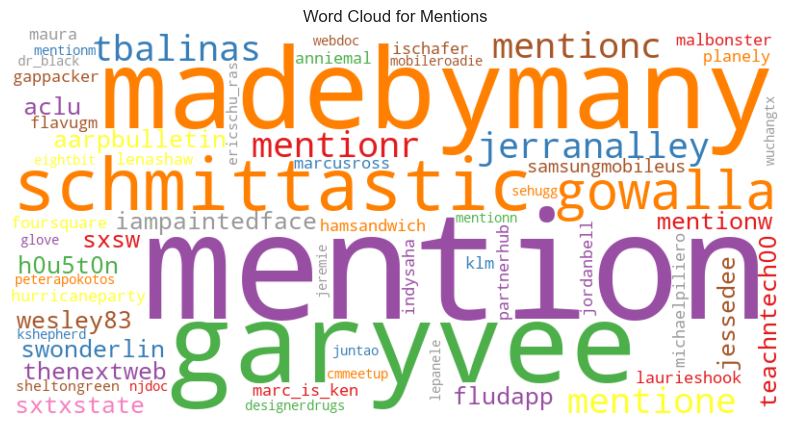

In [34]:
#getting top mentions 
top_mentions = mention_counter.most_common(100) 

# Generating a text string for mentions based on their frequencies
text_for_wordcloud = ' '.join([mention[0] for mention in top_mentions])

# Creating a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Set1').generate(text_for_wordcloud)

# Plotting the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Mentions')
plt.show()

In [35]:
#getting hashtags counts
hashtags_counts = df2['hashtags'].value_counts().reset_index()
hashtags_counts.columns = ['Hashtags', 'Counts']

#printing top hashtags
hashtags_counts.head()

,Hashtags,Counts
0,[#sxsw],4827
1,"[#sxsw, #sxswi]",97
2,"[#sxsw, #ipad2]",96
3,"[#apple, #sxsw]",96
4,"[#google, #sxsw]",59


####  WordCloud For Hashtags

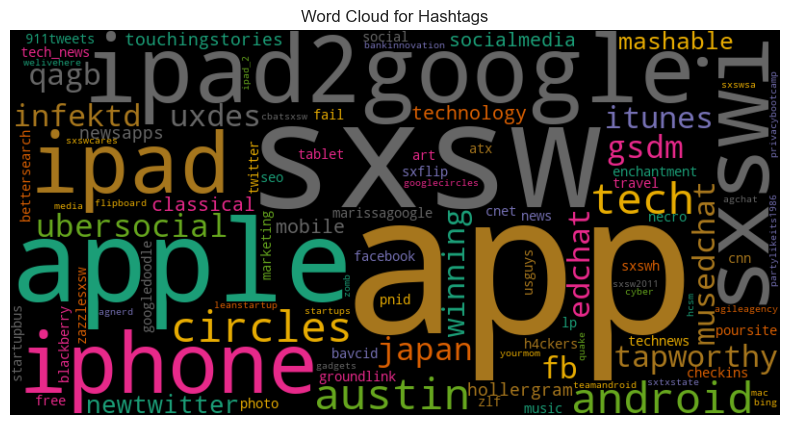

In [36]:
# Word cloud for hashtags
top_hashtags = hashtag_counter.most_common(100)

# Generating a text string for hashtags based on their frequencies
text_for_wordcloud = ' '.join([hashtag[0] for hashtag in top_hashtags])

# Creating a WordCloud object with a dark palette
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Dark2').generate(text_for_wordcloud)

# Plotting the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Hashtags')
plt.show()

Our analysis on  SXSW dataset unveils dynamic conversations Primarily hashtags like #sxsw, #ipad2, #apple, and #google indicate lively discussions, with a notable emphasis on technology and prominent brands. The sparse use of mentions, featuring placeholders like @mention, suggests a lower frequency of direct user interactions.

Diverse hashtags such as #android, #edchat, and #newsapps reflect a broad spectrum of topics, ranging from technology trends to global events. This diversity underscores the multidimensional nature of conversations during the SXSW conference.

In summary the dataset portrays an active engagement with key themes and brands through hashtags, while the limited use of mentions hints at a preference for broader topic exploration rather than direct user interactions. Further sentiment analysis on specific hashtags could provide deeper insights into public perceptions and sentiments surrounding the conference and featured brands.

# Modeling

There are different types of models you can use for sentiment analysis, including:

Traditional Machine Learning Models: Support Vector Machines (SVM), Naive Bayes, Logistic Regression.

Deep Learning Models: Recurrent Neural Networks (RNN), Long Short-Term Memory (LSTM) networks, Gated Recurrent Units (GRU), Transformer models (like BERT, GPT).

### Preprocessing

We split the dataset into two portions. The first portion will be for model training and the second for model testing using the train_test_split method

In [78]:
# Creating data and target dataframes for MODELING
X = df.drop(['sentiment'], axis=1)
y = df['sentiment']

# Specify to stratify since our target is imbalanced
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3,random_state=42,stratify=y)

Checking the X_train dataset after splitting

In [79]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6225 entries, 9021 to 1684
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      6225 non-null   object
 1   product   6225 non-null   object
 2   tokens    6225 non-null   object
 3   hashtags  6225 non-null   object
 4   mentions  6225 non-null   object
dtypes: object(5)
memory usage: 291.8+ KB


### NLP Process flow
1. Segmentation: Divide the complete document into sentences, using cues such as commas and full stops for separation.
2. Tokenization: Break down sentences into individual words, where each word is referred to as a token.
3. Stopword Removal: Eliminate words that primarily contribute to sentence coherence.
4. Stemming: Remove prefixes and suffixes from words, retaining only the base forms.
5. Lemmatization: Identify the base forms of words, considering variations in tense.
6. Speech Tagging: Assign tags to words based on their grammatical roles, such as verbs or nouns.
7. Named Entity Tagging: Familiarize the machine with popular culture names by tagging entities in the text.

#### Baseline_Model

We want to see how a model would perform before using any Natural Language Processing on the dataset. 
To do this, We first need to vectorize the training set (converting textual data into a numerical format that can be used as input for machine learning algorithms). We will begin by keeping our number of features small, utilizing only 20.

In [80]:
# Creating and fiting the TfidfVectorizer
tfidf = TfidfVectorizer(max_features=20)
X_train_vectorized = tfidf.fit_transform(X_train['text'])

# Accessing feature names using get_feature_names_out()
feature_names = tfidf.get_feature_names_out()

# Creating a DataFrame from the sparse matrix with feature names as columns
df_vectorized = pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=feature_names)

# Displayig the Vectorized DataFrame
df_vectorized.head()

,and,apple,at,for,google,in,ipad,iphone,is,link,mention,of,on,quot,rt,store,sxsw,the,to,up
0,0.0,0.306317,0.000000,0.00000,0.0,0.325215,0.0,0.0,0.00000,0.000000,0.000000,0.694492,0.0,0.000000,0.000000,0.000000,0.125263,0.482868,0.263123,0.0
1,0.0,0.435186,0.384459,0.00000,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.288426,0.000000,0.0,0.000000,0.395484,0.501793,0.177962,0.000000,0.373820,0.0
2,0.0,0.000000,0.000000,0.94004,0.0,0.000000,0.0,0.0,0.00000,0.232445,0.212408,0.000000,0.0,0.000000,0.000000,0.000000,0.131058,0.000000,0.000000,0.0
3,0.0,0.377160,0.333197,0.00000,0.0,0.000000,0.0,0.0,0.42466,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.434886,0.154233,0.594542,0.000000,0.0
4,0.0,0.553141,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.00000,0.200592,0.183301,0.000000,0.0,0.779364,0.000000,0.000000,0.113099,0.000000,0.000000,0.0


Creating a Multinomial Naive Bayes baseline model and evaluating it using cross-validation.

In [81]:
#Multinomial Bayes Baseline Model
baseline_model = MultinomialNB()

# Evaluate the model on X_train_vectorized and y_train
baseline_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)
baseline_cv.mean().round(4)


0.6026

This baseline model is performing right around 60%, approximately the same as if we assigned 'No Emotion' to all tweets. We will attempt to increase this accuracy through natural language processing and feature engineering on different models.

# Natural Language Processing

## First Model

### Multinomial Naive Bayes

### Feature Engineering

#### 1. Tokenize and Remove Punctuation

To begin with, We want to strip punctuation and split the string of text into individual text tokens.

In [82]:
# Creating a basic token pattern to remove punctuation when tokenizing
basic_token_pattern = r"(?u)\b\w\w+\b"
tokenizer = RegexpTokenizer(basic_token_pattern)

We use a tokenizer to tokenize the text in a DataFrame column and then create a new column called text_tokenized to store the tokenized results. 

In [83]:
# Creating a new columns for tokenized text
X_train['text_tokenized'] = X_train['text'].apply(tokenizer.tokenize)

#dispaying dataframe after tokenization
X_train.head()

,text,product,tokens,hashtags,mentions,text_tokenized
9021,"by the way, i love that y'all are so down to d...",Apple,"[way, love, discus, breed, midst, pre, madness]",[#sxsw],[],"[by, the, way, love, that, all, are, so, down,..."
5400,rt @mention anyone at #sxsw want to make a qui...,Apple,"[anyone, want, make, quick, hundred, dollar, n...","[#sxsw, #ipad2]",[@mention],"[rt, mention, anyone, at, sxsw, want, to, make..."
851,for those looking for hig-like guidelines when...,Google,"[look, hig, like, guideline, design, adam, bec...","[#uxamandroid, #sxsw]",[@mention],"[for, those, looking, for, hig, like, guidelin..."
3877,how long is the line at the #sxsw apple store ...,Apple,"[long, line, store, downtown]",[#sxsw],[],"[how, long, is, the, line, at, the, sxsw, appl..."
4094,&quot;apple likes it if you pay them. that's w...,Apple,"[quot, like, pay, like, quot, barry, diller, a...",[#sxsw],[@mention],"[quot, apple, likes, it, if, you, pay, them, t..."


#### 2.Removing Stopwords

Removing stopwords could increase the model's accuracy by eliminating words with little semantic value.  Before we remove stopwords from our training set, lets look at our current top 20 words.

In [84]:
#getting counts of how often each token appears in the entire training dataset
train_freq_dist = FreqDist(X_train['text_tokenized'].explode())

# displaying the result 
train_freq_dist

FreqDist({'sxsw': 6587, 'mention': 4855, 'the': 3091, 'link': 2950, 'to': 2465, 'at': 2155, 'rt': 2029, 'google': 1804, 'ipad': 1740, 'for': 1733, ...})

Plot the top 20 words based on their frequency.

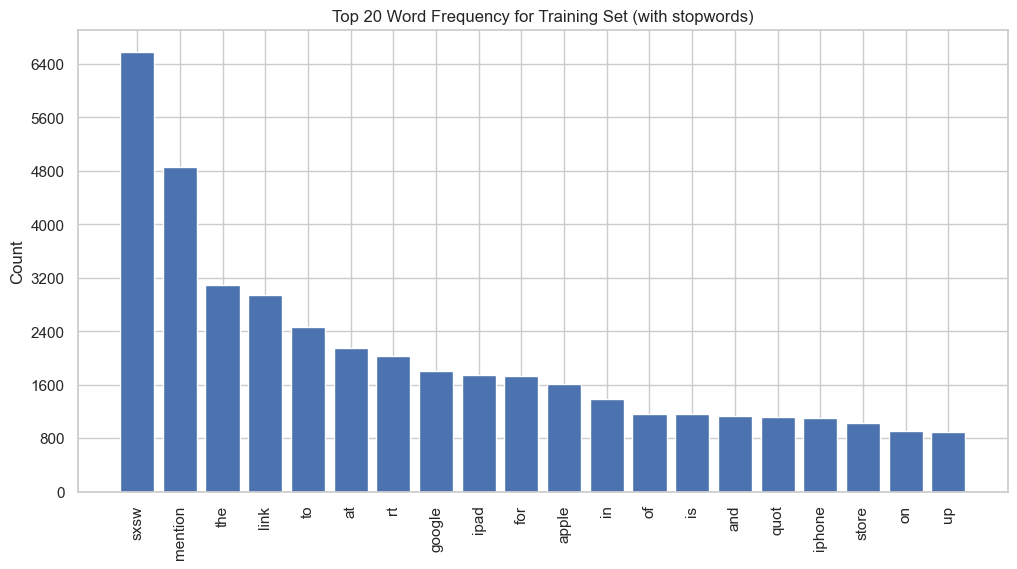

In [85]:
# Creating a function for plotting the top 20 words
def visualize_top_20(freq_dist, title):

    top_20 = list(zip(*freq_dist.most_common(20)))
    tokens = top_20[0]
    counts = top_20[1]

    fig, ax = plt.subplots(figsize=(12,6))
    ax.bar(tokens, counts)

    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)
    
visualize_top_20(train_freq_dist, 
                 "Top 20 Word Frequency for Training Set (with stopwords)")
plt.savefig('Top20withStopwords.jpg')

The majority, if not all, of these top 20 words are either stopwords or words pertaining to South by Southwest, Google, or Apple that do not carry any information on sentiment.We will remove these words to pare down our text to more meaningful words.

In [86]:
# Creating a list of english stopwords
stopwords = nltk.corpus.stopwords.words('english')

# Adding words specific to SXSW, Apple, or Google
sxsw = ['sxsw', 'sxswi', 'mention', 'link', 'rt', 'rtmention', 'quot', 
        'austin', 'google', 'ipad', 'apple', 'iphone', 'amp', 
        'android', 'ipad2']
stopwords.extend(sxsw)

# Creating a function for removing stopwords
def remove_stopwords(token_list):
    stopwords_removed = [token for token in token_list if token not in stopwords]
    return stopwords_removed

# Create a new column for text without stopwords
X_train['text_without_stopwords'] = X_train['text_tokenized'].apply(remove_stopwords)

#displaying the result
X_train.head()

,text,product,tokens,hashtags,mentions,text_tokenized,text_without_stopwords
9021,"by the way, i love that y'all are so down to d...",Apple,"[way, love, discus, breed, midst, pre, madness]",[#sxsw],[],"[by, the, way, love, that, all, are, so, down,...","[way, love, discuss, breeds, midst, pre, madness]"
5400,rt @mention anyone at #sxsw want to make a qui...,Apple,"[anyone, want, make, quick, hundred, dollar, n...","[#sxsw, #ipad2]",[@mention],"[rt, mention, anyone, at, sxsw, want, to, make...","[anyone, want, make, quick, hundred, dollars, ..."
851,for those looking for hig-like guidelines when...,Google,"[look, hig, like, guideline, design, adam, bec...","[#uxamandroid, #sxsw]",[@mention],"[for, those, looking, for, hig, like, guidelin...","[looking, hig, like, guidelines, designing, ad..."
3877,how long is the line at the #sxsw apple store ...,Apple,"[long, line, store, downtown]",[#sxsw],[],"[how, long, is, the, line, at, the, sxsw, appl...","[long, line, store, downtown]"
4094,&quot;apple likes it if you pay them. that's w...,Apple,"[quot, like, pay, like, quot, barry, diller, a...",[#sxsw],[@mention],"[quot, apple, likes, it, if, you, pay, them, t...","[likes, pay, likes, barry, diller, acc, ballro..."


Now that we have removed stopwords, lets look at our top 20 words again.

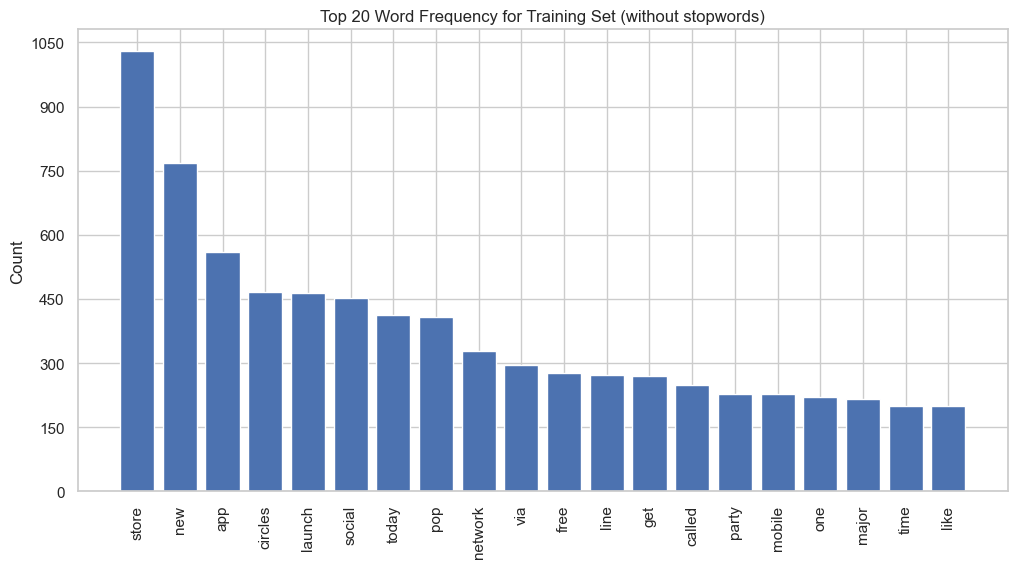

In [87]:
#getting  counts of how often each token appears in the entire training dataset
new_train_freq_dist = FreqDist(X_train['text_without_stopwords'].explode())

#plotting top frequent  tokens
visualize_top_20(new_train_freq_dist, 
                 "Top 20 Word Frequency for Training Set (without stopwords)")

plt.savefig('Top20withoutStopwords.jpg')

In [88]:
# Creating and fitting the 2nd TfidfVectorizer
tfidf = TfidfVectorizer(max_features=20, stop_words=stopwords)

# Join the tokenized lists into strings
X_train['joined_tokens'] = X_train['text_without_stopwords'].apply(lambda x: ' '.join(x))

# Fit and transform using the TfidfVectorizer
X_train_vectorized_2 = tfidf.fit_transform(X_train['joined_tokens'])

# Accessing feature names using get_feature_names_out()
feature_names = tfidf.get_feature_names_out()

# Creating a DataFrame from the sparse matrix with feature names as columns
df_vectorized_2 = pd.DataFrame.sparse.from_spmatrix(X_train_vectorized_2, columns=feature_names)

# Displaying the Vectorized DataFrame
df_vectorized_2.head()


,app,called,circles,free,get,launch,line,major,mobile,network,new,one,party,pop,social,store,temporary,time,today,via
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.74119,0.0,0.0,0.0,0.0,0.671296,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.827427,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.561573,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [89]:
# Evaluating the baseline model on the text without stopwords
stopwords_removed_cv = cross_val_score(baseline_model, 
                                       X_train_vectorized_2, 
                                       y_train)
stopwords_removed_cv

array([0.61044177, 0.60401606, 0.61526104, 0.61124498, 0.5935743 ])

Printing the mean cross-validated scores for your baseline model and the model with stopwords removed. We round off to four decimal places to make the output more readable

In [90]:
# Print the mean cross-validated score for the baseline model
print("Baseline:         ", round (baseline_cv.mean(), 4))

# Print the mean cross-validated score for the model with stopwords removed
print("Stopwords removed:", round (stopwords_removed_cv.mean(), 4))

Baseline:          0.6026
Stopwords removed: 0.6069


#### 3.Lemmatization

Lemmatization reduces each token to it's root word. For example, 'texts' and 'texting' would both be reduced to 'text'.

In [91]:
# Creating a function for lemmatizing
lemmatizer = WordNetLemmatizer()
def lemmatize_text(token_list):
    lemmatized_text = [lemmatizer.lemmatize(word) for word in token_list]
    return lemmatized_text

# Creating a new column for lemmatized text
X_train['lemmatized_text'] = X_train['text_without_stopwords'].apply(lemmatize_text)

#displaying xtrain
X_train.head()

,text,product,tokens,hashtags,mentions,text_tokenized,text_without_stopwords,joined_tokens,lemmatized_text
9021,"by the way, i love that y'all are so down to d...",Apple,"[way, love, discus, breed, midst, pre, madness]",[#sxsw],[],"[by, the, way, love, that, all, are, so, down,...","[way, love, discuss, breeds, midst, pre, madness]",way love discuss breeds midst pre madness,"[way, love, discus, breed, midst, pre, madness]"
5400,rt @mention anyone at #sxsw want to make a qui...,Apple,"[anyone, want, make, quick, hundred, dollar, n...","[#sxsw, #ipad2]",[@mention],"[rt, mention, anyone, at, sxsw, want, to, make...","[anyone, want, make, quick, hundred, dollars, ...",anyone want make quick hundred dollars new ad ...,"[anyone, want, make, quick, hundred, dollar, n..."
851,for those looking for hig-like guidelines when...,Google,"[look, hig, like, guideline, design, adam, bec...","[#uxamandroid, #sxsw]",[@mention],"[for, those, looking, for, hig, like, guidelin...","[looking, hig, like, guidelines, designing, ad...",looking hig like guidelines designing adam bec...,"[looking, hig, like, guideline, designing, ada..."
3877,how long is the line at the #sxsw apple store ...,Apple,"[long, line, store, downtown]",[#sxsw],[],"[how, long, is, the, line, at, the, sxsw, appl...","[long, line, store, downtown]",long line store downtown,"[long, line, store, downtown]"
4094,&quot;apple likes it if you pay them. that's w...,Apple,"[quot, like, pay, like, quot, barry, diller, a...",[#sxsw],[@mention],"[quot, apple, likes, it, if, you, pay, them, t...","[likes, pay, likes, barry, diller, acc, ballro...",likes pay likes barry diller acc ballroom pic,"[like, pay, like, barry, diller, acc, ballroom..."


Creating a frequency distribution (lemmatized_freq_dist) based on lemmatized text from your training set and then visualizing the top 20 words using the visualize_top_20 function. 

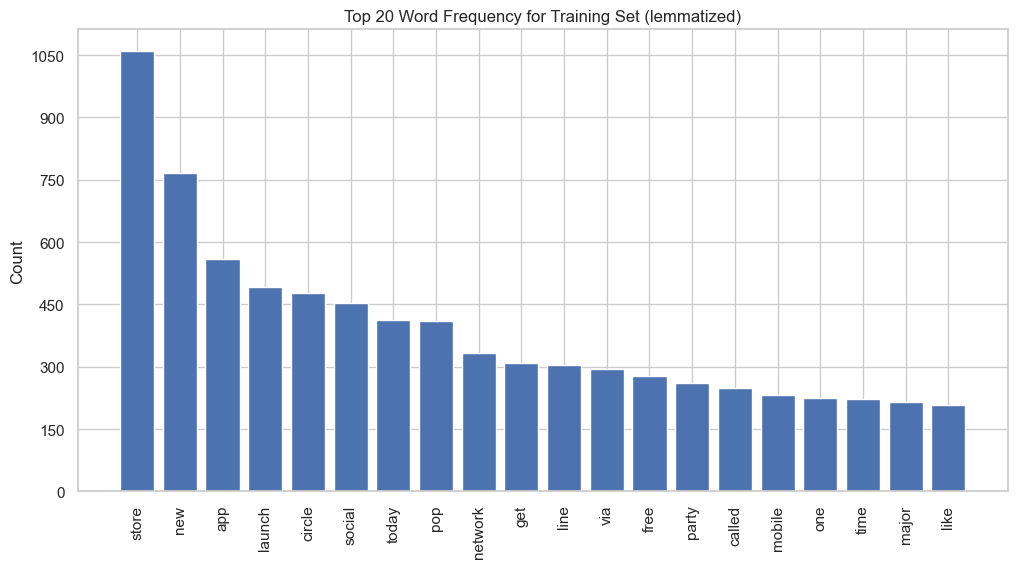

In [92]:
#getting  counts of how often each token appears in the entire training dataset
lemmatized_freq_dist = FreqDist(X_train['lemmatized_text'].explode())

#plotting
visualize_top_20(lemmatized_freq_dist, 
                 "Top 20 Word Frequency for Training Set (lemmatized)")

Creating a new DataFrame called X_train_preprocessed by dropping certain columns ('text', 'text_tokenized', 'text_without_stopwords', 'tokens') from original DataFrame X_train. 

This is the dataframe we will use for all models as it has been feature engineered with NLP.

In [93]:
# Create a dataframe with only the final text
X_train_preprocessed = X_train.drop(['text', 
                                     'text_tokenized', 
                                     'text_without_stopwords', 
                                     'tokens'], axis=1)
#displying preprocessed token
X_train_preprocessed.head()

,product,hashtags,mentions,joined_tokens,lemmatized_text
9021,Apple,[#sxsw],[],way love discuss breeds midst pre madness,"[way, love, discus, breed, midst, pre, madness]"
5400,Apple,"[#sxsw, #ipad2]",[@mention],anyone want make quick hundred dollars new ad ...,"[anyone, want, make, quick, hundred, dollar, n..."
851,Google,"[#uxamandroid, #sxsw]",[@mention],looking hig like guidelines designing adam bec...,"[looking, hig, like, guideline, designing, ada..."
3877,Apple,[#sxsw],[],long line store downtown,"[long, line, store, downtown]"
4094,Apple,[#sxsw],[@mention],likes pay likes barry diller acc ballroom pic,"[like, pay, like, barry, diller, acc, ballroom..."


In [94]:
print(X_train_preprocessed.columns)


Index(['product', 'hashtags', 'mentions', 'joined_tokens', 'lemmatized_text'], dtype='object')


Creating and fitting a TfidfVectorizer on our preprocessed text data, transforming the tokenized and lemmatized text into a format suitable for the TfidfVectorizer, and then creating a DataFrame (df_vectorized_3) from the sparse matrix generated by the TfidfVectorizer.

In [95]:
# Creating and fitting the 3rd TfidfVectorizer
tfidf = TfidfVectorizer(max_features=20)

# Join the tokenized lists into strings
X_train_preprocessed['joined_tokens'] = X_train_preprocessed['lemmatized_text'].apply(lambda x: ' '.join(x))

# Fit and transform using the TfidfVectorizer
X_train_vectorized_3 = tfidf.fit_transform(X_train_preprocessed['joined_tokens'])

# Accessing feature names using get_feature_names_out()
feature_names = tfidf.get_feature_names_out()

# Creating a DataFrame from the sparse matrix with feature names as columns
df_vectorized_3 = pd.DataFrame.sparse.from_spmatrix(X_train_vectorized_3, columns=feature_names)

# Displaying the Vectorized DataFrame
df_vectorized_3.head()


,app,called,circle,free,get,launch,like,line,major,mobile,network,new,one,party,pop,social,store,time,today,via
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.692824,0.0,0.0,0.000000,0.0,0.0,0.0,0.536076,0.0,0.0,0.0,0.0,0.482304,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.822272,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.569094,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


Evaluating our baseline model using cross-validation on the features obtained from the third TfidfVectorizer (X_train_vectorized_3). This is to assess how well the model performs with the engineered features.

In [96]:
# Evaluating the model based on lemmatized text
engineered_cv = cross_val_score(baseline_model, X_train_vectorized_3, y_train)
engineered_cv

array([0.61044177, 0.60321285, 0.61606426, 0.60722892, 0.59277108])

 Printing the mean cross-validated scores for three different scenarios: baseline model, model with stopwords removed, and engineered features. We round off to the nearest four decimal places.

In [97]:
# Comparing scores
print("Baseline:         ", round(baseline_cv.mean(), 4))
print("Stopwords removed:", round(stopwords_removed_cv.mean(), 4))
print("Engineered:       ", round(engineered_cv.mean(), 4))

Baseline:          0.6026
Stopwords removed: 0.6069
Engineered:        0.6059


## 2. Second Model

### Gated Recurrent Unit (GRU) 

In [98]:
# Preprocess data
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train['text'])

X_train_seq = tokenizer.texts_to_sequences(X_train['text'])
X_train_padded = pad_sequences(X_train_seq, maxlen=100, padding='post', truncating='post')

X_test_seq = tokenizer.texts_to_sequences(X_test['text'])
X_test_padded = pad_sequences(X_test_seq, maxlen=100, padding='post', truncating='post')

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Build the GRU Model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=32, input_length=100))
model.add(GRU(100))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the Model
model.fit(X_train_padded, y_train_encoded, epochs=5, batch_size=64, validation_split=0.2)

# Evaluate the Model
y_pred_prob = model.predict(X_test_padded)
y_pred = [1 if pred > 0.5 else 0 for pred in y_pred_prob]

accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")


Epoch 1/5
78/78 [==============================] - 20s 183ms/step - loss: -2.9097 - accuracy: 0.6052 - val_loss: -5.6199 - val_accuracy: 0.5920
Epoch 2/5
78/78 [==============================] - 12s 159ms/step - loss: -6.1504 - accuracy: 0.6052 - val_loss: -8.1682 - val_accuracy: 0.5920
Epoch 3/5
78/78 [==============================] - 12s 156ms/step - loss: -8.4057 - accuracy: 0.6052 - val_loss: -10.5989 - val_accuracy: 0.5920
Epoch 4/5
78/78 [==============================] - 13s 169ms/step - loss: -10.5361 - accuracy: 0.6052 - val_loss: -12.9543 - val_accuracy: 0.5920
Epoch 5/5
84/84 [==============================] - 4s 41ms/step
Test Accuracy: 0.6025


#### GRU Test Accuracy: 0.6025

## 3. Third Model


### Support Vector Machines (SVM)

In [99]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.3, random_state=42, stratify=df['sentiment'])

# Convert text to TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train the SVM model
svm_model = SVC(kernel='linear', C=1.0)
svm_model.fit(X_train_tfidf, y_train)

# Predictions
y_pred = svm_model.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Test Accuracy: 0.6868
Classification Report:
                  precision    recall  f1-score   support

Negative emotion       0.87      0.12      0.21       171
 Neutral emotion       0.70      0.87      0.78      1608
Positive emotion       0.63      0.47      0.54       890

        accuracy                           0.69      2669
       macro avg       0.73      0.48      0.51      2669
    weighted avg       0.69      0.69      0.66      2669



#### SVM Test Accuracy: 0.6868

## 4.Fourth Model


### Logistic Regression Model

In [104]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.3, random_state=42, stratify=df['sentiment'])

# Convert text to TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train the Logistic Regression model
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train_tfidf, y_train)

# Predictions
y_pred = logreg_model.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Test Accuracy: 0.6752
Classification Report:
                  precision    recall  f1-score   support

Negative emotion       0.64      0.05      0.10       171
 Neutral emotion       0.70      0.87      0.77      1608
Positive emotion       0.61      0.45      0.52       890

        accuracy                           0.68      2669
       macro avg       0.65      0.46      0.46      2669
    weighted avg       0.66      0.68      0.64      2669



#### Logistic Regression Model Test Accuracy: 0.6752

### Our best model is Support Vector Machines (SVM) performing at 68.68%.

## Final Model

Fit the final model on the full preprocessed training set.

Training our final model, Support Vector Machines model (final_model), using the features obtained from the fourth TfidfVectorizer (X_train_vectorized_3) then printing the training score of the final model.


In [120]:
# Train the SVM model
svm_model = SVC(kernel='linear', C=1.0)
svm_model.fit(X_train_tfidf, y_train)

# Predictions
y_pred = svm_model.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Fit final model and evaluate training score
# Use the same vectorizer used for training the initial SVM model
X_train_vectorized_3 = vectorizer.transform(X_train)

# Create and train the SVM model
final_model_svm = SVC(kernel='linear', C=1.0)
final_model_svm.fit(X_train_vectorized_3, y_train)

# Evaluate the SVM model
train_accuracy_svm = final_model_svm.score(X_train_vectorized_3, y_train)
print('Final SVM model training score:', train_accuracy_svm)


Test Accuracy: 0.6868
Classification Report:
                  precision    recall  f1-score   support

Negative emotion       0.87      0.12      0.21       171
 Neutral emotion       0.70      0.87      0.78      1608
Positive emotion       0.63      0.47      0.54       890

        accuracy                           0.69      2669
       macro avg       0.73      0.48      0.51      2669
    weighted avg       0.69      0.69      0.66      2669

Final SVM model training score: 0.8178313253012048


#### Final SVM model training score: 0.82

Vectorizing our test data using the same TfidfVectorizer (tfidf) that we used for our training data. After vectorizing the test data, we are evaluating the test score of our final model and printing the rounded test score.

In [122]:
# Vectorize X_test
X_test_vectorized = vectorizer.transform(X_test["text"])

# Ensure y_test is in the correct format
y_test = y_test.flatten()  # Remove .values

# Evaluate test score and round to four decimal places
final_model_test_score = final_model_svm.score(X_test_vectorized, y_test)
rounded_test_score = round(final_model_test_score, 4)

# Print the rounded test score
print('Final model test score:', rounded_test_score)


Final model test score: 0.6868


Up to this point, We have been evaluating our models based off of accuracy.  However, since we are concerned with both false positives and false negatives, F1 score might be a better indication of how the model is performing.

In [123]:
# Printing a classification report
y_pred = final_model_svm.predict(X_test_vectorized)


print(classification_report(y_test, y_pred))

                  precision    recall  f1-score   support

Negative emotion       0.87      0.12      0.21       171
 Neutral emotion       0.70      0.87      0.78      1608
Positive emotion       0.63      0.47      0.54       890

        accuracy                           0.69      2669
       macro avg       0.73      0.48      0.51      2669
    weighted avg       0.69      0.69      0.66      2669



The model excels in recognizing neutral emotions, exhibiting a high precision and recall, leading to a substantial F1-score. However, its performance diminishes when dealing with negative and positive emotions. The notably low precision for both negative and positive emotions implies a considerable number of false positives, undermining the accuracy of predictions in these categories. Furthermore, the lower recall for positive emotion indicates that the model misses a significant proportion of actual positive instances. Despite these challenges, the F1-score for neutral emotion showcases a balanced performance, emphasizing its proficiency in identifying this specific emotion class.

Plotting a confusion matrix:

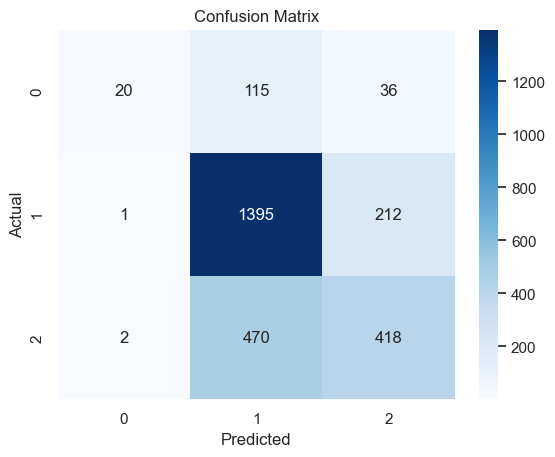

In [126]:
# X_test_vectorized and y_test are defined
y_pred = final_model_svm.predict(X_test_vectorized)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix using seaborn heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('ConfusionMatrix.jpg')
plt.show()


There were relatively few negative sentiment tweets in our training and test sets.  With the few tweets, our model could not accurately identify the negative sentiment tweets.

### <span style="color:blue">Text Patterns</span>

Before moving on to our recommendations, We thought it would be interesting to create Word Clouds for positive and negative tweets.

In [127]:
# Create a dataframe with the text and the target
train_set = pd.concat([X_train_preprocessed, y_train], axis=1)

train_set.head()

,product,hashtags,mentions,joined_tokens,lemmatized_text,sentiment
9021,Apple,[#sxsw],[],way love discus breed midst pre madness,"[way, love, discus, breed, midst, pre, madness]",Positive emotion
5400,Apple,"[#sxsw, #ipad2]",[@mention],anyone want make quick hundred dollar new ad h...,"[anyone, want, make, quick, hundred, dollar, n...",Positive emotion
851,Google,"[#uxamandroid, #sxsw]",[@mention],looking hig like guideline designing adam beck...,"[looking, hig, like, guideline, designing, ada...",Neutral emotion
3877,Apple,[#sxsw],[],long line store downtown,"[long, line, store, downtown]",Neutral emotion
4094,Apple,[#sxsw],[@mention],like pay like barry diller acc ballroom pic,"[like, pay, like, barry, diller, acc, ballroom...",Negative emotion


### <span style="color:blue">"Positive emotion"_Wordcloud</span>

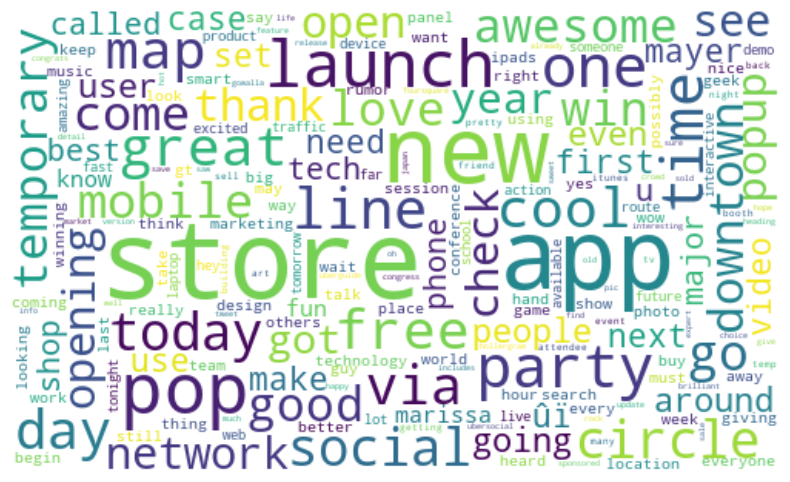

In [130]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#Train_set is a DataFrame with a 'sentiment' column and 'joined_lemmatized' column for text
positive_corpus = train_set.loc[train_set['sentiment'] == 'Positive emotion', 'joined_tokens'].tolist()
positive_text = ' '.join(positive_corpus)

# Generating a word cloud image
wordcloud = WordCloud(width=500,
                      height=300,
                      collocations=False,
                      background_color='white',
                      max_font_size=70).generate(positive_text)

# Displaying the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# Saving the word cloud image
plt.savefig('PositiveWordCloud.jpg')
plt.show()


### <span style="color:blue">"Negative emotion" WordCloud</span>

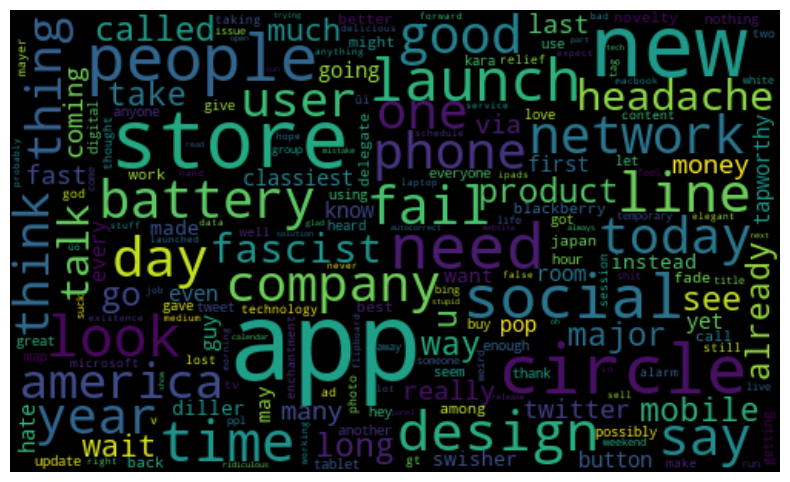

In [131]:
# Filtering negative tweets and create a corpus
negative_corpus = train_set.loc[train_set['sentiment'] == 'Negative emotion', 'joined_tokens'].tolist()
negative_text = ' '.join(negative_corpus)

# Generating a word cloud image
wordcloud_negative = WordCloud(width=500,
                               height=300,
                               collocations=False,
                               max_font_size=70).generate(negative_text)

# Displaying the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis("off")

# Saving the word cloud image
plt.savefig('NegativeWordCloud.jpg')
plt.show()


## Model Serialization

#### Save model in serial form before deploying.Since we using sckikit-learn's 'MultinomialNB', we apply  'joblib' library for serialization.

In [133]:
from joblib import dump

# Save the model
dump(final_model_svm, 'nlp_model.joblib')

['nlp_model.joblib']

## Deploying the model

In [134]:
!pip install streamlit
# Save this as app.py
import streamlit as st
from joblib import load

# Load the model
model = load('nlp_model.joblib')

def predict_sentiment(text):
    # Vectorize the input text
    text_vectorized = tfidf.transform([text])

    # Make predictions
    prediction = model.predict(text_vectorized)

    return prediction[0]

def main():
    st.title("Sentiment Analysis App")
     # Get user input
    user_input = st.text_area("Enter text for sentiment analysis:", "")

    if st.button("Predict"):
        # Perform sentiment analysis
        prediction = predict_sentiment(user_input)

        # Display the result
        st.success(f"Predicted Sentiment: {prediction}")

if __name__ == "__main__":
    main()

  Obtaining dependency information for streamlit from https://files.pythonhosted.org/packages/d3/96/9251b421d0a1c7d625a82a04bea56b8a9830c785940ec16db454b85c6db7/streamlit-1.29.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for altair<6,>=4.0 from https://files.pythonhosted.org/packages/c5/e4/7fcceef127badbb0d644d730d992410e4f3799b295c9964a172f92a469c7/altair-5.2.0-py3-none-any.whl.metadata
  Obtaining dependency information for blinker<2,>=1.0.0 from https://files.pythonhosted.org/packages/fa/2a/7f3714cbc6356a0efec525ce7a0613d581072ed6eb53eb7b9754f33db807/blinker-1.7.0-py3-none-any.whl.metadata
  Obtaining dependency information for rich<14,>=10.14.0 from https://files.pythonhosted.org/packages/be/be/1520178fa01eabe014b16e72a952b9f900631142ccd03dc36cf93e30c1ce/rich-13.7.0-py3-none-any.whl.metadata
  Obtaining dependency information for tzlocal<6,>=1.1 from https://files.pythonhosted.org/packages/97/3f/c4c51c55ff8487f2e6d0e618dba917e3c3ee2caae6cf0fbb59c9b1876f2e/tzlo

2023-12-15 01:36:17.538 
  command:

    streamlit run C:\Users\Eunice Nduati\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


# Conclusion and Recommendations

## Conclusion

The model demonstrates strengths in recognizing neutral emotions, and strategic adjustments, along with continuous improvement efforts, are essential to enhance its performance in handling negative and positive emotions for a more robust and versatile sentiment analysis tool. The Support Vector Machines (SVM) model, our best performer, achieves an accuracy of 68.68%, serving as a solid foundation for further refinement and optimization.

## Recommendations

1. Wordcloud Analysis: Utilize word clouds to compare frequently used words and identify those specifically associated with positive or negative sentiments. This approach can assist SXSW in flagging tweets containing these distinct words for sentiment identification.

2. Augmenting Dataset for Imbalance: Address the class imbalance by collecting more tweets labeled as positive or negative. Increasing the training data for these sentiments can enhance the model's accuracy and improve sentiment categorization.

3. Refining Stopwords and Tokenization: Identify and remove additional SXSW-specific stopwords to refine tokenization. This process aims to focus on words with more semantic value, contributing to a more accurate sentiment analysis.

4. Hyperparameter Tuning: Explore hyperparameter tuning for the SVM model and other potential algorithms. Adjusting parameters can optimize the model's performance, making it more adept at distinguishing between various emotional sentiments.

These strategies collectively contribute to a comprehensive approach for improving sentiment analysis, addressing challenges, and enhancing the model's effectiveness in capturing nuanced emotions related to SXSW.

## Next Steps

**Exploring sentiments for specific products**

Diving into which products are tweeted about favorably vs which ones are not. As we have already noticed, Apple has many more favorable tweets than Google does. This could help SXSW know which vendors are worth inviting/promoting.

**Part of speech tagging for accurate lemmatization.**

Currently, our lemmatization is only functioning for nouns, not for verbs (ex: 'calling' is not lemmatized to 'call').  By instituting part of speech tagging to identify verbs and then lemmatize them could help our model's performance.